# Phase 2 - Evaluate the Recall metric and analyze the unbalanced class

#### Summary of all steps executed in this notebook
- Start loading the 3 exported models (xgb and gbm) with higher accuracy and run the predictions.
<br> These models were exported in previous notebooks and were built using the ML frameworks sklearn and h2o.ai
- Build new machine learning models with the additional techniques explained below and
- Evaluate the machine learning model with higher RECALL metric for deployment
<br> Recall metric is one good option to evaluate this type of scenario (customer churn) 
<br> Recall is also known as Sensitivity or True positive rate(TPR)

#### Additional techniques trying to improve the performance of the ML model, such as:
- Evaluation of unbalanced classification / class weight
- Smote technique for oversampling the training dataset
- Apply Standard Scale in the data before build the ML models, and compare with previous results using default data format

## Quick recap of previous notebooks - Machine Learning with Python

#### Build 15 machine learning using different frameworks -  XGBoost, LightGBM, Sklearn, H2O.ai and Apache Spark
- 2 ML models in 1x5
- 6 ML models in 2x6
- 4 ML models in 3x6
- 3 ML models in 4x6

#### Model evaluation
- Previous notebooks use the global metric accuracy for evaluation

#### Starting process... load python modules and also connect to h2o cluster

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Remove warnings
import warnings
warnings.filterwarnings("ignore")

## Machine Learning Models
import h2o
from h2o.estimators import H2OXGBoostEstimator, H2OGradientBoostingEstimator
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

## Sklearn Metrics - Classification and model selection
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             roc_auc_score, recall_score, roc_auc_score)

from sklearn.model_selection import train_test_split

## Scale data
from sklearn.preprocessing import scale

# import imblearn - SMOTE
from imblearn.over_sampling import SMOTE

## Load ML models
import pickle

## connect to h2o cluster and remove all object
h2o.connect(ip='192.168.56.102')
h2o.remove_all()

Connecting to H2O server at http://192.168.56.102:54321 ... successful.


H2O cluster uptime:,5 hours 38 mins
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,7 months and 23 days !!!
H2O cluster name:,userds1
H2O cluster total nodes:,1
H2O cluster free memory:,5.746 Gb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"


### Load and prepare the dataset to build ML models
- H2O - pandas Dataframe with raw data
- Sklearn - Numpy arrays with One Hot Encode for categorical columns

In [2]:
## Load and prepare the dataset to build ML models - Customer churn
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.loc[(df.tenure==0) & (df.TotalCharges == ' '), ['TotalCharges', 'tenure']] = 0
df['TotalCharges'] = df['TotalCharges'].astype('float')

current_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PaymentMethod' , 'Churn', 'Contract']

df = df[current_features]

## H2O DATA - FORMAT AS DATA FRAME WITHOUT ONE HOT ENCODE
target = 'Churn'
features_h2o = df.columns.to_list()
features = features_h2o.copy()
features.remove(target)

X = df[features].copy()
y = df[target]

SEED = 42
X_train_h2o, X_test_h2o, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

X_train_h2o[target] = y_train
X_test_h2o[target] = y_test

## Convert to h2o Frame
train_h2o = h2o.H2OFrame(X_train_h2o, destination_frame='train.hex')
train_h2o[target] = train_h2o[target].asfactor()
test_h2o = h2o.H2OFrame(X_test_h2o, destination_frame='test.hex')
test_h2o[target] = test_h2o[target].asfactor()

## SKLEARN with One  Hot Encode and format  as Numpy Array
## One Hot Encode for categorical features - sklearn

target_1_0 = lambda x: ['No', 'Yes'].index(x)
df[target] = df[target].apply(target_1_0)

OHE_cols = ['gender', 'PaymentMethod' , 'Contract']
df = pd.get_dummies(data=df, columns=OHE_cols)

features = df.columns.to_list()
features.remove(target)

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

df.head(2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,1,29.85,29.85,0,1,0,0,0,1,0,1,0,0
1,34,56.95,1889.50,0,0,1,0,0,0,1,0,1,0


### Export statistics information for new predictions

In [3]:
## Export stats information from training data and 1 row as example  for new predictions
df_stats = pd.DataFrame(X_train, columns=features)
df_stats = df_stats.describe(include='all')
# df_stats['idx_cols'] = df_stats.index
df_stats.to_csv('./ML_models/stats_df_train.csv', sep=',')

### Export samples of data for new predictions
- First export will provide the data in the correct format expected by the GBM for prediction
- The second example will provide in the standard format just to show how to build the entire data pipeline for prediction


In [4]:
# ## Export 1 row as exmple for new predictions - all information
# df_pred = pd.DataFrame(X_test[:1], columns=features)
# df_pred.to_csv('./ML_models/pred_example.csv', sep=',', index=False)

## 1 - Expected format by the GBM Model for prediction
pd.DataFrame(X_test[:1], columns=features).to_csv('./ML_models/pred_example_correct_format.csv', sep=',', index=False)

## 2 - Data in the standard format - must apply all rules to run the prediction with GBM model
X_test_h2o.iloc[:1, X_test_h2o.columns != 'Churn'].to_csv('./ML_models/pred_baseline_example.csv', sep=',', index=False)

### Machine Learning models
- First let's create one aux function to help in the model evaluation

In [5]:
## Function to print Confusion Matrix and metrics
def rpt_metrics_report(y_true, y_pred, msg_model='MODEL XPTO', rpt_confusion_matrix=False):
    """Print metrics """
    
    accuracy_score_rpt = accuracy_score(y_true, y_pred)
    recall_score_rpt = recall_score(y_true, y_pred)
    auc_rpt = roc_auc_score(y_true, y_pred)
    
    print('Model: ', msg_model)
    print('--   Accuracy: ', accuracy_score_rpt)
    print('--   AUC     : ', auc_rpt)
    print('--   Recall  : ', recall_score_rpt)
    print('')
    if rpt_confusion_matrix:
        report = classification_report(y_true, y_pred)
        confusion_matrix_rpt = confusion_matrix(y_true, y_pred)
        print('--   Confusion Matrix')
        print('0   FP')
        print('FN  1')
        print('')
        print(confusion_matrix_rpt)
        print('')
        print('')
        print('--   Metrics report')
        print(report)
        print('')

### Load the machine learning models already build and start the evaluation using the metric recall

##### GBM and XBG (sklearn and h2o) 
- These 3 models presented below have similar accuracy score and were the ones that had the best results
<br> exported previously in specific notebook

In [6]:
## Load models and validate 
print('')
print('ML prediction - sklearn baseline models')
print('')

## GBM model 
file_export_model = './ML_models/model_GBM_baseline_v1.sav'
gbm_model = pickle.load(open(file_export_model, 'rb'))
y_pred_gbm = gbm_model.predict(X_test)
rpt_metrics_report(y_test, y_pred_gbm, 'GBM')

## XGB model 
file_export_model = './ML_models/model_XGB_baseline_v1.sav'
xgb_model = pickle.load(open(file_export_model, 'rb'))
y_pred_xgb = xgb_model.predict(X_test)
rpt_metrics_report(y_test, y_pred_xgb, 'XGB')

## H2O baseline models
## get model exported - predict and generate target in numeric format

## XGB model
export_model_path = "./ML_models/model_xgb_v1/fit_xgb.model"
h2o_model_xgb = h2o.load_model(export_model_path)
# model_xgb.model_performance()
ypred_XGB_df = h2o_model_xgb.predict(test_h2o).as_data_frame()
y_pred_h2o = ypred_XGB_df['predict'].apply(target_1_0)
y_true_test_h2o = X_test_h2o[target].apply(target_1_0).values
rpt_metrics_report(y_true_test_h2o, y_pred_h2o, 'H2O - XGB')


ML prediction - sklearn baseline models

Model:  GBM
--   Accuracy:  0.8
--   AUC     :  0.7095220490261945
--   Recall  :  0.5127388535031847

Model:  XGB
--   Accuracy:  0.7991397849462366
--   AUC     :  0.7019112033599947
--   Recall  :  0.49044585987261147

xgboost prediction progress: |████████████████████████████████████████████| 100%
Model:  H2O - XGB
--   Accuracy:  0.7918279569892474
--   AUC     :  0.7580903355115246
--   Recall  :  0.6847133757961783



### 1st Machine learning model insight
- The 3 models have similar accuracy between 79% and 80%, however the model with H2O (xgb) has an AUC 5% higher
- Recall with xgb using H2O.ai framework is 68,47% => 17% higher than the others
<br> The H2O XGB is currently the model that provide the best performance in general

The difference between these 2 executions are mainly related to default hyper parameter used by each framework 
<br> (ML model and framework - sklearn vs. h2o.ai)
<br> Some examples:
- GBM with sklearn use learning rate = 0.1 and xgb with H2O.ai use eta/learning rate = 0.3 as can be seen below.
- Number of trees, and so on...

#### GBM with sklearn

In [7]:
gbm_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### XGB with H2O.ai

In [8]:
h2o_model_xgb.default_params

{'model_id': None,
 'training_frame': None,
 'validation_frame': None,
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': 'AUTO',
 'fold_column': None,
 'response_column': None,
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': 'AUTO',
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': -1,
 'distribution': 'AUTO',
 'tweedie_power': 1.5,
 'categorical_encoding': 'AUTO',
 'quiet_mode': True,
 'export_checkpoints_dir': None,
 'ntrees': 50,
 'max_depth': 6,
 'min_rows': 1.0,
 'min_child_weight': 1.0,
 'learn_rate': 0.3,
 'eta': 0.3,
 'sample_rate': 1.0,
 'subsample': 1.0,
 'col_sample_rate': 1.0,
 'colsample_bylevel': 1.0,
 'col_sample_rate_per_tree': 1.0,
 'colsample_bytree': 1.0,
 'max_abs_leafnode_pred': 0.0,
 'max_delta_step': 0.0,


#### To finalize the evaluation and decide which model to deploy in production additional techniques will be applied
- Apply Standard Scale in the data before build the machine learning model
- Evaluate the balance of target class and optimize the model execution

## Evaluation of target class distribution
- Churn    : ~ 26%%
- No churn : ~ 73%

In [9]:
print('Target class distribution - all data')
print(pd.value_counts(df[target]))
print(pd.value_counts(df[target])/len(df[target]))
print('')
print('Target class distribution - train dataset')
print(pd.value_counts(y_train))
print(pd.value_counts(y_train)/len(y_train))

Target class distribution - all data
0    5174
1    1869
Name: Churn, dtype: int64
0    0.73463
1    0.26537
Name: Churn, dtype: float64

Target class distribution - train dataset
0    3477
1    1241
dtype: int64
0    0.736965
1    0.263035
dtype: float64


### Machine learning models with scale and class weight
#### XGB - sklearn
- Standard Scale applied and scale_pos_weight = class weight
- Recall achieved : 82,0%

In [10]:
class_weight = sum(y_train == 0) / sum(y_train == 1) ## total 0:3477 / total 1: 1241 = 2.8017727639000807
print('Class weight: ' , class_weight)

Class weight:  2.8017727639000807


In [11]:
## XGB with class weight - scale_pos_weight

## Scale data - only tenure and charges (numeric values)
scale_trainX = scale(X_train[:, [0, 1, 2]])
scale_trainX = np.concatenate((scale_trainX, X_train[:, 3:12 ]), axis = 1)

scale_testX = scale(X_test[:, [0, 1, 2]])
scale_testX = np.concatenate((scale_testX, X_test[:, 3:12 ]), axis = 1)

model_xgb_scale = xgb.XGBClassifier(random_state=SEED, scale_pos_weight=class_weight)
model_xgb_scale.fit(scale_trainX, y_train)

y_pred_xgb_scale = model_xgb_scale.predict(scale_testX)
rpt_metrics_report(y_test, y_pred_xgb_scale, 'XGB - CLASS WEIGHT')

Model:  XGB - CLASS WEIGHT
--   Accuracy:  0.7436559139784946
--   AUC     :  0.7677218883830214
--   Recall  :  0.8200636942675159



### 2nd Insight
- The accuracy score is 5% worse however the recall metric is much higher
- XGB with scale and class weight achieved 82% of recall

## GBM execution with Standard Scale and SMOTE to balance the class - Churn
- GBM with sklearn does not have the option to inform the class weight to the algorithm, so let´s balance the class with SMOTE

#### GBM - model evaluation
- Recall of 86,30%

In [12]:
# SMOTE with imblearn
from imblearn.over_sampling import SMOTE
smote_bal = SMOTE(random_state=SEED)
X_smote, y_smote = smote_bal.fit_resample(scale_trainX, y_train)

## GBM smote
model_GBM_smote = GradientBoostingClassifier(random_state=SEED)
model_GBM_smote.fit(X_smote, y_smote)

y_pred_gbm_smote = model_GBM_smote.predict(scale_testX)
rpt_metrics_report(y_test, y_pred_gbm_smote, 'GBM - scale and SMOTE ')

print('Balance class - Churn')
print(pd.value_counts(y_smote))

Model:  GBM - scale and SMOTE 
--   Accuracy:  0.7290322580645161
--   AUC     :  0.7712458103284553
--   Recall  :  0.8630573248407644

Balance class - Churn
1    3477
0    3477
dtype: int64


### Execute the same process with XGB without class weight but with SMOTE and standard scale
- Recall: 85,50% and a bit small than GBM

In [13]:
## GBM smote
model_XGB_smote = xgb.XGBClassifier(random_state=SEED)
model_XGB_smote.fit(X_smote, y_smote)

y_pred_xgb_smote = model_XGB_smote.predict(scale_testX)
rpt_metrics_report(y_test, y_pred_xgb_smote, 'XGB - scale and SMOTE ')

Model:  XGB - scale and SMOTE 
--   Accuracy:  0.7286021505376344
--   AUC     :  0.7684434689917389
--   Recall  :  0.8550955414012739



#### GBM - model evaluation - sample with hyper parameter optimization
- Recall: 88,05% => almost 2% higher compared to default GBM parameters
- Export gbm model for deployment - best recall metric

In [14]:
## tune GBM sample
model_GBM_smote = GradientBoostingClassifier(random_state=SEED, learning_rate=0.3, n_estimators=200, max_depth=5)
model_GBM_smote.fit(X_smote, y_smote)

y_pred_gbm_smote = model_GBM_smote.predict(scale_testX)
rpt_metrics_report(y_test, y_pred_gbm_smote, 'GBM - scale and SMOTE ')

## Export model for production deployment
file_export_model = './ML_models/model_GBM_prod_v1.sav'
pickle.dump(model_GBM_smote, open(file_export_model, 'wb'))
print("Model exported")

Model:  GBM - scale and SMOTE 
--   Accuracy:  0.6619354838709678
--   AUC     :  0.7307992936204393
--   Recall  :  0.8805732484076433

Model exported


### To finalize this process let's run the class imbalance with H2O
- Xgb in h2o framework does not have in version 3.26 the option of scale weight or balance_class
<br> however other ML algorithms have the option to inform balance_classes=True
- Execution of GBM and GLM (2 models as example) just to evaluate the results with balance class = True

In [15]:
from h2o.estimators import H2OGradientBoostingEstimator, H2OGeneralizedLinearEstimator, H2ODeepLearningEstimator

In [16]:
## H2O SMOTE AND BALANCE
hfeatures = features_h2o.copy()
hfeatures.remove(target)
glm_h2o_smote_cw = H2OGeneralizedLinearEstimator(balance_classes=True, seed=SEED, family='binomial')
glm_h2o_smote_cw.train(
    x = hfeatures,
    y = target,
    training_frame = train_h2o)
y_pred_glm_smote = glm_h2o_smote_cw.predict(test_h2o).as_data_frame()
y_pred_glm_h2o = y_pred_glm_smote['predict'].apply(target_1_0)
rpt_metrics_report(y_true_test_h2o, y_pred_glm_h2o, 'H2O - GLM - SCALE AND BALANCE CLASS')

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Model:  H2O - GLM - SCALE AND BALANCE CLASS
--   Accuracy:  0.7664516129032258
--   AUC     :  0.7672883770160155
--   Recall  :  0.7691082802547771



In [17]:
## GBM - H2O SMOTE AND BALANCE
gbm_h2o_smote_cw = H2OGradientBoostingEstimator(balance_classes=True, seed=SEED)
gbm_h2o_smote_cw.train(
    x = hfeatures,
    y = target,
    training_frame = train_h2o)
y_pred_gbm_smote = gbm_h2o_smote_cw.predict(test_h2o).as_data_frame()
y_pred_gbm_h2o = y_pred_gbm_smote['predict'].apply(target_1_0)
rpt_metrics_report(y_true_test_h2o, y_pred_gbm_h2o, 'H2O - GBM - SCALE AND BALANCE CLASS')

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Model:  H2O - GBM - SCALE AND BALANCE CLASS
--   Accuracy:  0.7131182795698925
--   AUC     :  0.763855004522781
--   Recall  :  0.8742038216560509



- Resume with h2o: GLM recall is 10% worse than GBM, and GBM with balance_class achieved 87,42%

## Confusion matrix - compare GBM model (baseline) vs GBM  with scale and SMOTE
- Detailed evaluation between these 2 models already exported

#### The GBM model using sklearn achieved the best result
- Recall / TPR : 88,05%

In [18]:
## GBM model 

## Baseline model v1
file_export_model = './ML_models/model_GBM_baseline_v1.sav'
gbm_model = pickle.load(open(file_export_model, 'rb'))
y_pred_gbm = gbm_model.predict(X_test)
rpt_metrics_report(y_test, y_pred_gbm, 'GBM', rpt_confusion_matrix=True)

## GBM Model for production
file_export_model = './ML_models/model_GBM_prod_v1.sav'
gbm_model_v2 = pickle.load(open(file_export_model, 'rb'))
y_pred_gbm_smote = gbm_model_v2.predict(scale_testX)
rpt_metrics_report(y_test, y_pred_gbm_smote, 'GBM - scale and SMOTE ', rpt_confusion_matrix=True)


Model:  GBM
--   Accuracy:  0.8
--   AUC     :  0.7095220490261945
--   Recall  :  0.5127388535031847

--   Confusion Matrix
0   FP
FN  1

[[1538  159]
 [ 306  322]]


--   Metrics report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1697
           1       0.67      0.51      0.58       628

    accuracy                           0.80      2325
   macro avg       0.75      0.71      0.72      2325
weighted avg       0.79      0.80      0.79      2325


Model:  GBM - scale and SMOTE 
--   Accuracy:  0.6619354838709678
--   AUC     :  0.7307992936204393
--   Recall  :  0.8805732484076433

--   Confusion Matrix
0   FP
FN  1

[[986 711]
 [ 75 553]]


--   Metrics report
              precision    recall  f1-score   support

           0       0.93      0.58      0.72      1697
           1       0.44      0.88      0.58       628

    accuracy                           0.66      2325
   macro avg       0.68      0.73      0.65     

## 3rd Insight and feature importance
- The global metric accuracy drop between these 2 models, however RECALL is more important to focus on -> Customer churn
- The recall / True Positive Rate increase from 51,27% to 88,05%


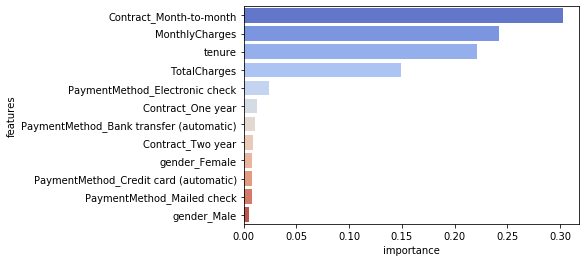

In [19]:
# Plot feature importance
feature_importances = pd.DataFrame({'features': features, 
                            'importance': gbm_model_v2.feature_importances_}).sort_values('importance', ascending=False)

ax = sns.barplot(x="importance", y="features", data=feature_importances, palette="coolwarm")

# Summary

## Top 3 main important features related to churn (Yes) are:
- Month-to-Month contract
- Small to Medium Tenure and associated with
- Higher Monthly Charges


### Final considerations
###### The recall metric was increased in 71,73% between baseline model and the final version -  (88,05% versus 51,27%) 
- Using the right technique it is possible to build machine learning models that really help in business. The current model chosen for deployment will provide higher customer base of possible churners to interact with focus on customer retention
<br>
<br> In this example of the final GBM model deployed the recall metric is 88,05% and much higher than the first GBM model

###### The next and final notebook will resume all information provided by previous notebooks and build the final script for deployment

In [4]:
# !jupyter nbconvert --to html Phase_2_Build_ML_models_with_Python_5x6_evaluation_using_RECALL_metric.ipynb